# Final Big Data

La intención de esta notebook es mostrar un poco las características de Spark a la hora de realizar Machine Learning gracias a su librería integrada.

### Pyspark con MlLib
Vamos a utilizar las utilidades que provee spark para realizar un proceso completo para un entrenamiento de un modelo, tuning y evaluación de un set de datos. 

### Forma de utilizarlo
Se va a correr spark dentro de contenedor de docker, y a su vez dentro de notebook de jupyter. 
Hay otros enfoques como utilizar [Apache Toree](https://toree.apache.org/) (para scala) u otras notebooks como [Apache Zeppelin](https://zeppelin.apache.org/).

Otra forma que si probé, es utilizar Google Colab: 

```
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar xf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install pyspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"

import findspark
findspark.init()

```

Lo cual puede ser sencillo a la hora de hacer pruebas. (ver versiones y links). 

Las instrucciones para correr el contenedor se encontrarán en el archivo de README.

## Dataset
En la carpeta datasets podremos encontrar el 'heart.csv', el cual vamos a utilizar para predecir si una persona está o no enferma.

Columnas: 
- age: age in years
- sex: (1 = male; 0 = female)
- cp: chest pain type
-- Value 0: asymptomatic
-- Value 1: atypical angina
-- Value 2: non-anginal pain
-- Value 3: typical angina
- trestbps: resting blood pressure (in mm Hg on admission to the hospital)
- chol: serum cholestoral in mg/dl
- fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- restecg: resting electrocardiographic results
-- Value 0: showing probable or definite left ventricular hypertrophy by Estes' criteria
-- Value 1: normal
-- Value 2: having ST-T wave abnormality
- thalach: maximum heart rate achieved
- exang: exercise induced angina (1 = yes; 0 = no)
- oldpeak: ST depression induced by exercise relative to rest
- slope: the slope of the peak exercise ST segment. 0: downsloping; 1: flat; 2: upsloping
- ca: number of major vessels (0-3) colored by flourosopy
- thal:
-- 1 = fixed defect;
-- 2 = normal; 
-- 7 = reversable defect
- target: 1 or 0


Lo que vamos a intentar *predecir* es la columna "target". 
El valor verdadero es 1 que indica "disease" o "enfermo".

Mayor información [aquí](https://www.kaggle.com/ronitf/heart-disease-uci)

# URL's
Urls que nos pueden llegar a servir para verificar spark: 
- http://localhost:4040/jobs/
- http://localhost:8080/ 

In [58]:
# esta librería nos permite utilizar spark dentro de las notebooks facilmente
import findspark
findspark.init()

In [59]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

from pyspark.ml.feature import QuantileDiscretizer
from pyspark.sql.functions import log, isnan, isnull, when, udf
from pyspark.sql.types import FloatType

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [ ]:
# SparkContext podemos crear uno solo
sc = SparkContext(master = 'local[2]')

In [61]:
# SparkContext almacena una sesion (por eso hacemos getOrCreate)
spark = (SparkSession 
    .builder 
    .master("local[2]")
    .appName("Utilizando Mllib") 
    .getOrCreate())

In [62]:
df = spark.read.csv('datasets/heart.csv', header=True)

In [63]:
# visualizamos nuestros datos
df.show()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 63|  1|  3|     145| 233|  1|      0|    150|    0|    2.3|    0|  0|   1|     1|
| 37|  1|  2|     130| 250|  0|      1|    187|    0|    3.5|    0|  0|   2|     1|
| 41|  0|  1|     130| 204|  0|      0|    172|    0|    1.4|    2|  0|   2|     1|
| 56|  1|  1|     120| 236|  0|      1|    178|    0|    0.8|    2|  0|   2|     1|
| 57|  0|  0|     120| 354|  0|      1|    163|    1|    0.6|    2|  0|   2|     1|
| 57|  1|  0|     140| 192|  0|      1|    148|    0|    0.4|    1|  0|   1|     1|
| 56|  0|  1|     140| 294|  0|      0|    153|    0|    1.3|    1|  0|   2|     1|
| 44|  1|  1|     120| 263|  0|      1|    173|    0|      0|    2|  0|   3|     1|
| 52|  1|  2|     172| 199|  1|      1|    162|    0|    0.5|    2|  0|   3|

In [64]:
print("Nuestro dataset tiene: {} elementos".format(df.count()))
print("De los cuales: {} representan enfermos".format(df.filter(df.target == 1).count()))
print("Y : {} representan sanos".format(df.filter(df.target == 0).count()))

Nuestro dataset tiene: 303 elementos
De los cuales: 165 representan enfermos
Y : 138 representan sanos


In [65]:
# Verificamos si hay missing values en las columnas
for c in df.columns: 
    hasNulls = df.filter(df[c].isNull()).count()
    print("Columna {} - {} null".format(c, hasNulls))

Columna age - 0 null
Columna sex - 0 null
Columna cp - 0 null
Columna trestbps - 0 null
Columna chol - 0 null
Columna fbs - 0 null
Columna restecg - 0 null
Columna thalach - 0 null
Columna exang - 0 null
Columna oldpeak - 0 null
Columna slope - 0 null
Columna ca - 0 null
Columna thal - 0 null
Columna target - 0 null


In [66]:
#Revisamos el tipo de columnas, son todas strings! y deberían ser númericas
print("antes {}".format(df.dtypes))
for c in df.columns:
    if (dict(df.dtypes)[c] == 'string'):
        if (c == 'oldpeak'):
            df = df.withColumn(c, df[c].cast('float'))
        else:
            df = df.withColumn(c, df[c].cast('integer'))
print("=======================")
print("antes {}".format(df.dtypes))

antes [('age', 'string'), ('sex', 'string'), ('cp', 'string'), ('trestbps', 'string'), ('chol', 'string'), ('fbs', 'string'), ('restecg', 'string'), ('thalach', 'string'), ('exang', 'string'), ('oldpeak', 'string'), ('slope', 'string'), ('ca', 'string'), ('thal', 'string'), ('target', 'string')]
antes [('age', 'int'), ('sex', 'int'), ('cp', 'int'), ('trestbps', 'int'), ('chol', 'int'), ('fbs', 'int'), ('restecg', 'int'), ('thalach', 'int'), ('exang', 'int'), ('oldpeak', 'float'), ('slope', 'int'), ('ca', 'int'), ('thal', 'int'), ('target', 'int')]


In [67]:
# Retornamos stats básicos para todas las columnas (lo ponemos en pandas para que se vea bien)
df.describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,303,54.366336633663366,9.08210098983786,29,77
sex,303,0.6831683168316832,0.46601082333962385,0,1
cp,303,0.966996699669967,1.0320524894832983,0,3
trestbps,303,131.62376237623764,17.5381428135171,94,200
chol,303,246.26402640264027,51.83075098793005,126,564
fbs,303,0.1485148514851485,0.35619787492797644,0,1
restecg,303,0.528052805280528,0.525859596359298,0,2
thalach,303,149.64686468646866,22.90516111491409,71,202
exang,303,0.32673267326732675,0.46979446452231655,0,1


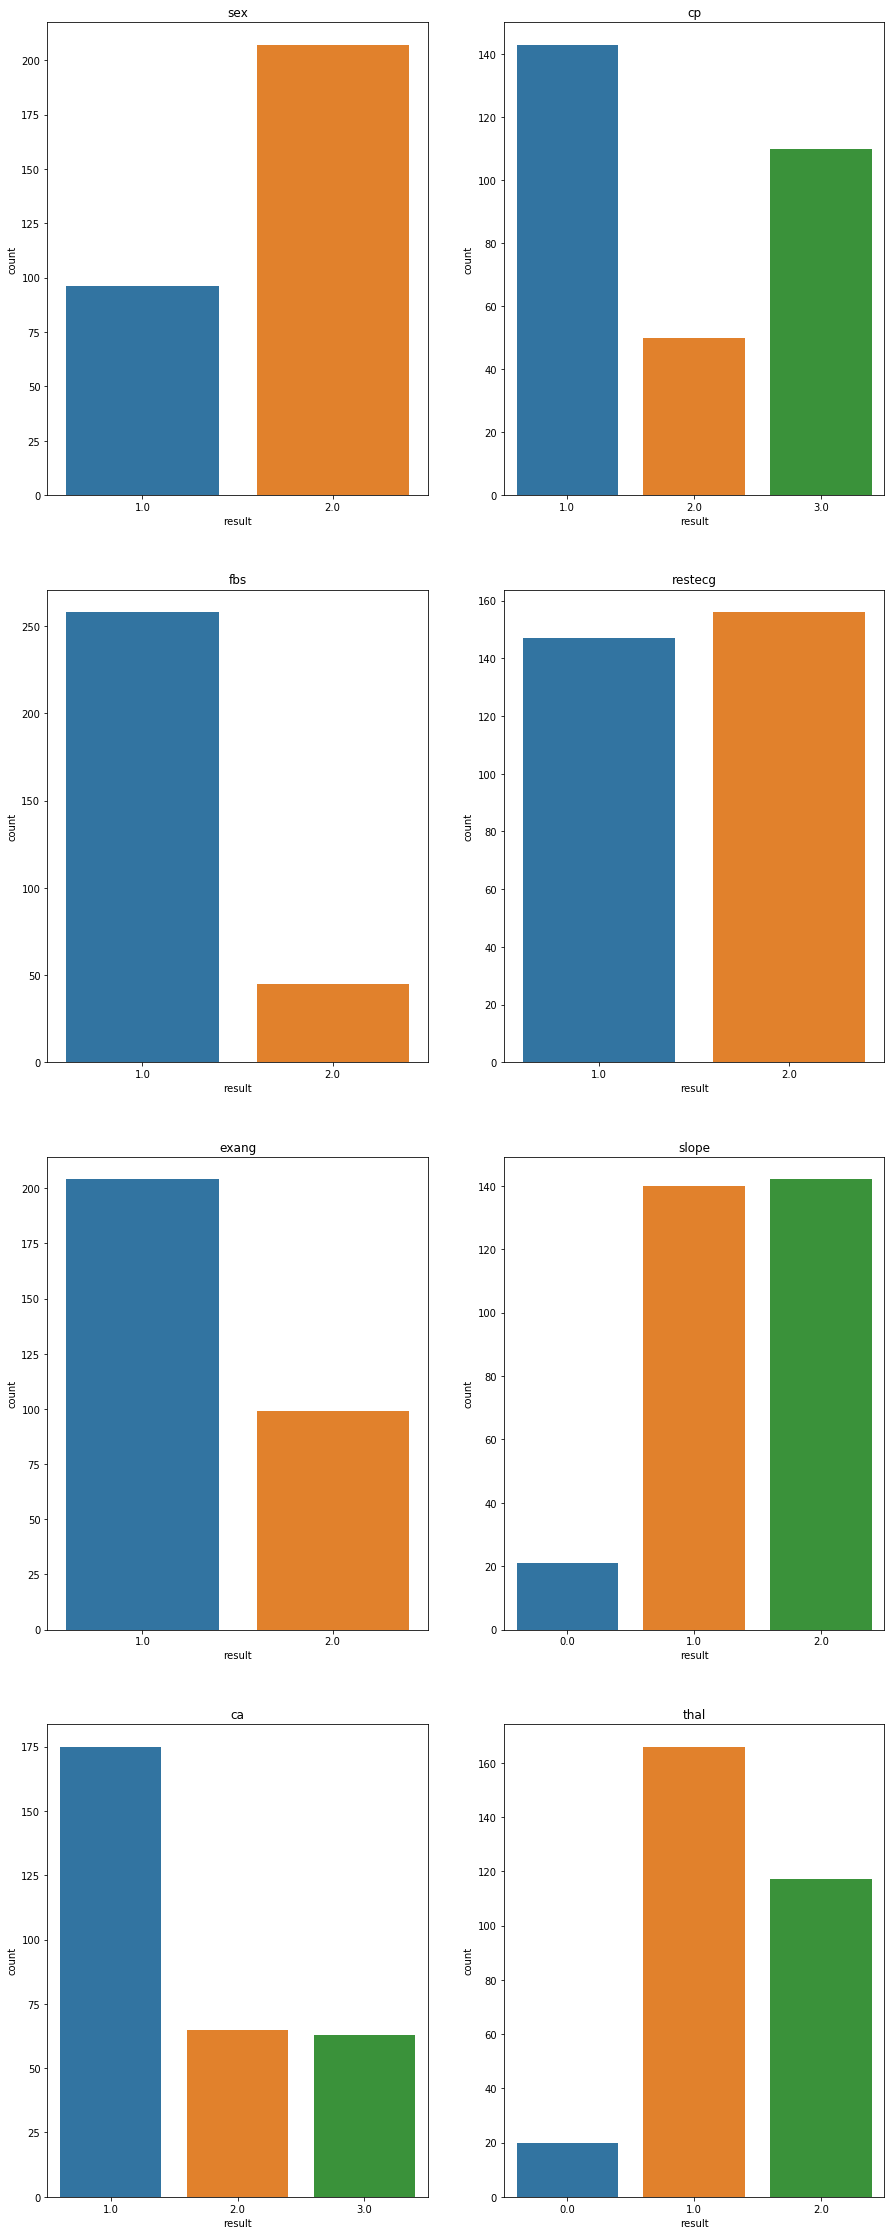

In [68]:
# Discretizamos las columnas para graficar histogram y density plot


columns = ["sex","cp", "fbs", "restecg", "exang", "slope", "ca", "thal", "target"]
fig, axes = plt.subplots(len(columns)//2, 2, figsize=(15,40))

for c, ax in zip(columns, np.array(axes).flatten()):
    discretizer = QuantileDiscretizer(numBuckets=10, inputCol=c, outputCol="result")
    result = discretizer.fit(df).transform(df)
    result = result.groupby('result').count().toPandas()
    ax.set_title(c)
    sns.barplot(x='result',y='count', data=result, ax=ax)


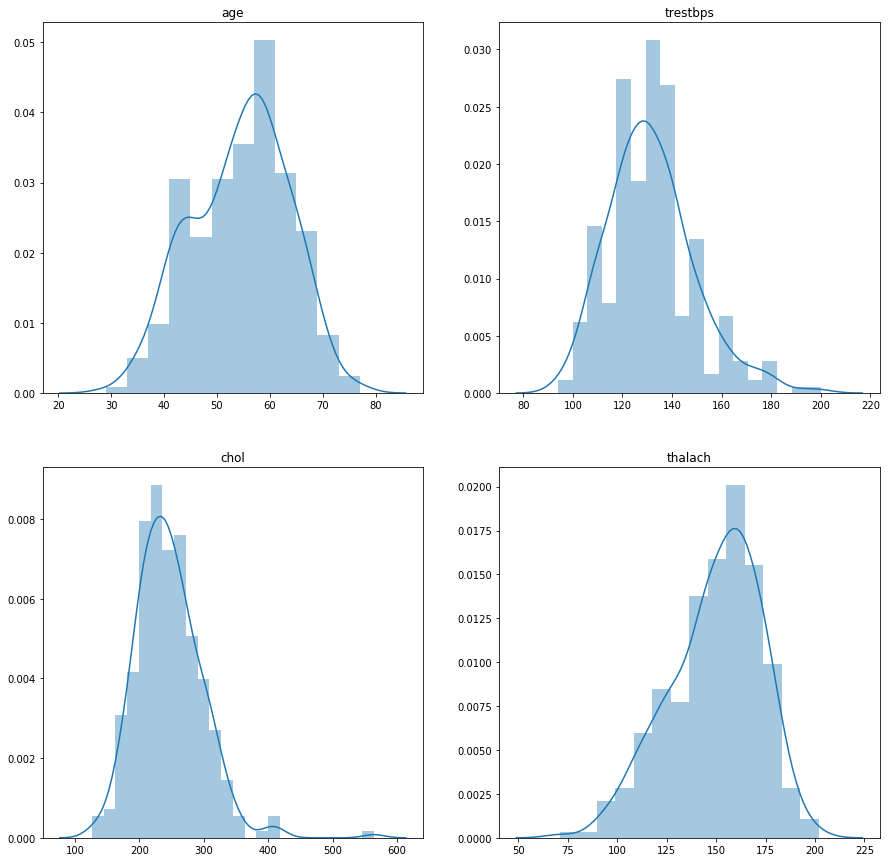

In [69]:
# para ver un gráfico un poco mejor con hist y kde
columns = ["age", "trestbps", "chol", "thalach", "oldpeak"]
fig, axes = plt.subplots(len(columns)//2, 2, figsize=(15,15))

for c, ax in zip(columns, np.array(axes).flatten()):
    d = df.select(c).toPandas()
    ax.set_title(c)
    sns.distplot(d, ax=ax)

Como conclusión al analisis exploratorio vemos que: 
- se comportan como categoricas: sex,cp, fbc, resteg, exang, slope, ca, thal
- age, trestbps, chol, thalach oldpeak son distribuciones que podriamos modificar para que se comporten como normales ( aplicar logaritmo, ....)

## Feature Engineering
En pyspark tenemos las utilidades de mllib, que nos permiten crear un pipeline de Machine Learning. El mismo estará compuesto por:
- Transformers: Es una función que transforman Dataframe en otro Dataframe. Implementa la función transform()
- Estimators: Amplía el concepto de un algoritmo que aprende. Implementa el método fit(). Recibe un DataFrame y retorna un Transformer.

Un Pipeline es una secuencia de Transformers y Estimators, nos permite ejecutar nuestro flujo de trabajo repetidamente.

Vamos a realizar un pipeline para transformar las variables categóricas en one-hot encoding, normalizar las columnas númericas. Se agrupará todos estos cambios en una función `transform`

In [70]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler

In [71]:
num_columns = ["age", "trestbps", "chol", "thalach", "oldpeak"]
cat_columns = ["sex","cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

def transform(df):
    scalers = []
    
    for c in num_columns:
         # VectorAssembler Transformation - convierte columna en un vector
        scalers.append(VectorAssembler(inputCols=[c],outputCol=c+"_vect"))
        
        # Estandarizamos las variables númericas discretas
        scalers.append(
            StandardScaler(
                inputCol=c+"_vect", 
                outputCol=c+"_scaled",
                withStd=True, 
                withMean=False)
        )
        
    #realizamos one-hot encoding de las variables categóricas
    for c in cat_columns:
        def to_array(col):
            """
            https://stackoverflow.com/questions/38384347/how-to-split-vector-into-columns-using-pyspark
            """
            def to_array_(v):
                return v.toArray().tolist()
            return udf(to_array_, ArrayType(DoubleType()))(col)
        
        # TODO: mejorar, muy lento pasar de DF to RDD
        values = df.select(c).distinct().rdd.map(lambda r: r[0]).collect()
        for v in values:
            df = df.withColumn("{}_{}".format(c,v), when(df[c] == v, 1).otherwise(0))
                
    # aplicamos el escalamiento
    num_pipe = Pipeline(stages=scalers)
    df = num_pipe.fit(df).transform(df)

    # quitamos la vectorizacion
    scaled_columns = list(filter(lambda a: "_scaled" in a, df.columns))
    def get_first(col):
        def index(v):
            return float(v[0])
        return udf(index, FloatType())(col)

    for c in scaled_columns:
        df = df.withColumn(c, get_first(c))

    # obtenemos las nuevas columnas categoricas
    new_columns = list(filter(lambda a: ("_" in a) and ("vect" not in a), df.columns))
    
    # creamos una nueva columna tipo vector con las features que nuestro modelo usará
    feature_assembler = vec_assembler = VectorAssembler(
        inputCols= new_columns, 
        outputCol='features'
    )
    
    # agregamos target
    df = df.withColumn("label", df.target)

    return feature_assembler.transform(df).select("features", "label"), new_columns

In [72]:
df, features = transform(df)

Mllib necesita que las features con las que se entrenará el modelo, se encuentren en un VectorDense y tengan el nombre `features`, también debe tener la columna `label` que indica el valor a clasificar del modelo.
________


## Model Training and Evaluation
Mllib ofrece modelos para clasificación, regresion, clustering, reglas (interesante para ver items frecuentes). También tiene capacidades para realizar tuning de hiperparámetros y evaluación de los mismos.

Se realizará la evaluación con una métrica que se utiliza en Clasificación: Curva roc-auc.
La métrica corresponde a valores entre 0 y 1, 1 indica una buena clasificación.

In [73]:
import pyspark.ml.evaluation as evals

In [73]:
# Create a BinaryClassificationEvaluator
evaluator = evals.BinaryClassificationEvaluator(metricName="areaUnderROC")

In [74]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier

In [75]:
# separamos nuestro dataset en train y test
train, test = df.randomSplit([0.66, 0.33])

Vamos a realizar la prueba con 3 arboles, aunque Pyspark posee más modelos de clasificación.
- DecisionTree: un simple arbol de clasificación
- RandomForest: un bosque que utiliza la técnica de bagging
- GBT o GradientBoosting: un bosque que utiliza la técnica de boosting
    
[Diferencia entre Bagging y Boosting](https://quantdare.com/what-is-the-difference-between-bagging-and-boosting/)

In [171]:
# instanciamos nuestros modelos con los parámetros default
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
gbt = GBTClassifier()

In [172]:
# realizaremos unas pruebas simples inicialmente
# por cada modelo, vamos a entrenar con los parámetros default, verificando el bias - variance tradeoff
models = []
for m  in [dt, rf, gbt]:
    
    # train model
    model = m.fit(train)
    
    # make predictions
    train_pred = model.transform(train)
    test_pred = model.transform(test)
    
    print(100*"=")
    print("{} - Bias: {}".format(m.__class__.__name__, evaluator.evaluate(train_pred)))
    print("{} - Variance: {}".format(m.__class__.__name__, evaluator.evaluate(test_pred)))
    
    models.append(model)

DecisionTreeClassifier - Bias: 0.9805312566673778
DecisionTreeClassifier - Variance: 0.7566964285714285
RandomForestClassifier - Bias: 0.9932792831235333
RandomForestClassifier - Variance: 0.8701923076923077
GBTClassifier - Bias: 1.0
GBTClassifier - Variance: 0.7292239010989012


Como podemos observar, nuestros modelos tienen una buena performance con respecto a nuestro dataset de train, pero la performance en el dataset de test es más baja. Esto es un comportamiento esperable, ya que hay datos en la muestra los cuales no conoce, similar a lo que ocurriría en un escenario real.

Cuando nuestro modelo detecta correctamente nuestros datos de train, pero no detecta bien nuestros datos de test decimos que estamos "sobreentrenados" ó "high bias".

Este comportamiento es una propiedad estadística donde si mejoramos nuestro "bias" o sesgo con los datos de train, nos estamos "memorizando" nuestro dataset. El problema, es que el modelo no puede "generalizar", es decir no puede predecir correctamente sobre datos que nunca vió (dataset de test).

Tenemos que encontrar hiperparámetros que nos permitan mejorar la predicción en train, y luego `regularizarlo` para que los datos en test no sean mal predecidos (lo que se suele decir High Variance).

[Bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff)  

Los modelos de árboles retornan la importancia (peso) que le dieron a cada columna para las predicciones.
Graficamos los mismos para cada modelo, y verificar que importancia le dieron a cada una.

In [137]:
def plot_feature_importance(importances, features, top_n = 15, title="Feature Importances"):
    """
    Imprime un gráfico de barras horizontal que indica la importancia de las features.
    """
    feat_imp = pd.DataFrame({'importance':importances})    
    feat_imp['feature'] = features
    feat_imp.sort_values(by='importance', ascending=False, inplace=True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace=True)
    feat_imp = feat_imp.set_index('feature', drop=True)
    feat_imp.plot.barh(title=title, figsize=(10,6))
    plt.xlabel('Feature Importance Score')
    plt.show()

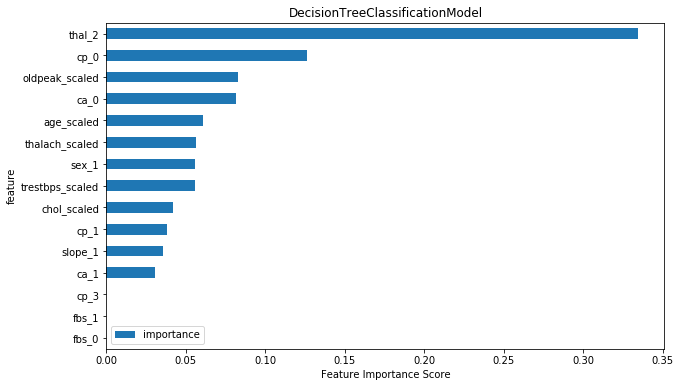

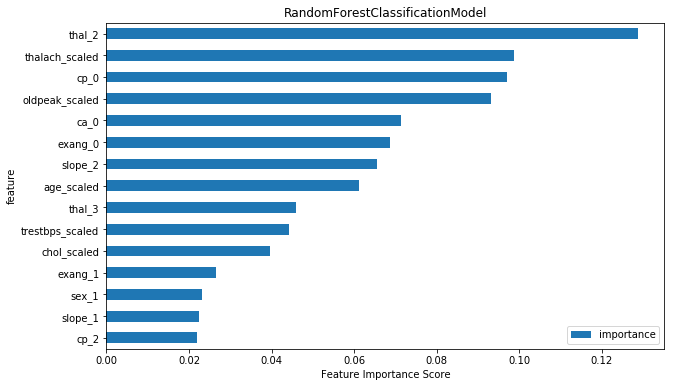

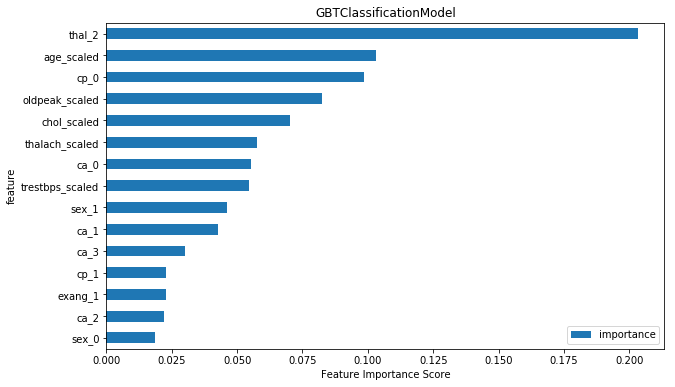

In [138]:
for m in models:
    plot_feature_importance(m.featureImportances.toArray(), features, title=m.__class__.__name__)

Si observamos, nuestros modelos le dieron pesos similares a ciertas características. 
Podríamos utilizar algunos elementos estadísticos para quitar las features, pero por ahora vamos a seguir trabajando con todas las mismas features. 

Continuamos el análisis con RandomForest, ya que es el modelo que se encuentra en medio para mejorar en train y en test, y seguir practicando con la librería.

> **Nota: Podríamos utilizar DecisionTree. GBT tiende a overfitear y solo tendríamos que regularizarlo.**
______________

Nota: para ver la estructura del árbol descomentar la siguiente linea
[ver](https://img-9gag-fun.9cache.com/photo/aOYA1mE_700bwp.webp)

In [143]:
# rf.fit(train).toDebugString

_______

## Tuning de nuestro modelo

Estadisticamente, hay varias maneras de entrenar/tunear/testear un modelo de ML:
- podemos hacer hold-out, dividir el segmento en 3, uno para train y validation; otro para test.
- podemos hacer cross-validation
    - dividir el dataset en k partes 
    - entrenar el modelo con k-1 partes
    - testearlo con la parte que guardamos
    - iteramos para que cada parte puede ser utilizada como test.
    - la métrica del modelo corresponde a todas las provista por los datos no vistos.
    
Mllib posee abstracciones para ambos mecanismos: TrainValidationSplit y CrossValidator. 

- ParamGridBuilder nos permite generar una grilla de hiperparámetros para testear
- Las clases de tuning reciben de parámetros:
    - estimator: nuestro modelo 
    - estimatorParamMaps: la grilla generada por ParamGridBuilder
    - evaluator: un evaluator, en nuestro caso ROC-AUC

In [153]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [272]:
rf = RandomForestClassifier()

grid = (
    ParamGridBuilder()
    .addGrid(rf.maxDepth, [3, 4, 5, 6]) # profundidad: regularization
    .addGrid(rf.numTrees, [10, 20, 50, 80, 100, 150 ]) # arboles
    .addGrid(rf.subsamplingRate, [0.8]) # validation split
    .build()
)

La grilla trabaja por fuerza bruta: prueba todas las combinaciones de hiperparámetros:

In [296]:
"cantidad de combinaciones: {}".format(len(grid))

'cantidad de combinaciones: 24'

In [273]:
cv = CrossValidator(
    estimator=rf,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    collectSubModels=True,
    numFolds=3
#     seed=12345
)

In [274]:
model = cv.fit(train)

In [273]:
cv generará un modelo para cada combinación de la grilla, y por dicho modelo realizará las siguientes prueba:
- dividir el dataset de train en 3 (folds)
- tomar 2, entrenar, evaluar con el restante (validation fold)
- repetir hasta haber evaluado con cada fold no visto.

In [297]:
"Cantidad de submodelos almacenados: {}".format(np.array(model.subModels).size)

'Cantidad de submodelos almacenados: 72'

Si analizamos el modelo viejo, los paramétros default son: 
- numTrees = 20,
- subsampling = 1, 
- maxDepth=5

El cual se encuentra entre las combinaciones posibles de la grilla. 
(lo traemos para comparar)

In [299]:
old_model = models[1]

Evaluamos el mejor modelo en test y verificamos contra el viejo:

In [304]:
# En el dataset de train
evaluator.evaluate(model.transform(train)), evaluator.evaluate(old_model.transform(train)) 

(0.9639428205675264, 0.9932792831235333)

Observamos que tenemos una peor performance con respecto al modelo con los parámetros default con respecto al dataset de train.

Esto podrían ser dos sintomas: que el modelo no está overfitteado (bueno), o que está underfit (malo).

En este caso, la métrica es buena (96%)

Lo más importante, verificar con los datos que el modelo aún no vio:

In [305]:
# En el dataset de test
evaluator.evaluate(model.transform(test)), evaluator.evaluate(old_model.transform(test)) 

(0.8870192307692308, 0.8701923076923077)

Como vemos, el modelo tiene una mejor performance en los datos que aún no vio, con respecto al modelo anterior.

Esto es un buen sintoma, pero hemos perdido 3% con el dataset de train (bias error) para sumar solo 1% en el dataset de test.

Realizamos la prueba de comportamiento general del modelo, evaluando con todos los datos:

In [317]:
# En todo el dataset
pred_all = model.transform(df)
evaluator.evaluate(pred_all), evaluator.evaluate(old_model.transform(df))

(0.9369784804567401, 0.9589811155028545)

La predicción general del modelo para el dataset entero es del 93.69 %, un poco más baja que para el modelo default.

Normalmente en ML se suele volver a entrenar todo el dataset con todos los datos para realizar esta prediccion. Obtenemos los mejores parámetros y volvemos a entrenar con el dataset completo.


Por defecto, CrossValidator almacena el mejor modelo, cuando realizamos `transform` lo utiliza para devolvernos nuestras predicciones.

Un atajo para utilizarlo es llamar a la property `bestModel`

In [321]:
evaluator.evaluate(model.bestModel.transform(test))

0.8870192307692308

Podemos obtener los parámetros con los cuales se entrenó el mejor modelo, y almacenarlos:

In [322]:
def get_best_parameters(cvModel):
    """
    Retorna los parametros de entrenamiento del mejor modelo
    """
    params = cvModel.bestModel.extractParamMap().items()
    return { k.name: v for k,v in params }


In [327]:
params = get_best_parameters(model)
params['numTrees'], params["maxDepth"]

(100, 3)

Y podríamos entrenar un nuevo modelo con los mismos:

In [363]:
final_model = RandomForestClassifier(**params).fit(df)
evaluator.evaluate(
    final_model
    .transform(df)
)

0.9440931049626691

Obtenemos un 94% en la métrica de clasificación, lo cual no es un mal número. 

Además, sabemos que nuestro estimador no está overfiteado, y se adapta mejor a los resultados que aún no ha visto.

El modelo retorna la probabilidad de la clase la cual predijo en la columna `predictions`.
Lo que podemos hacer es graficar un histograma / diagrama de densidad, para ver la distribución.
Esto nos mostraría con que seguridad nuestro modelo tiende a predecir una etiqueta:

In [358]:
def get_prob(arr, disease):
    """
    0: no disease
    1: disease
    """
    return list(map(lambda a: a['probability'].toArray()[disease], arr))

disease_prob = get_prob(model.bestModel.transform(test).filter("prediction == 1").select("probability").collect(), 0)
no_disease_prob = get_prob(model.bestModel.transform(test).filter("prediction == 0").select("probability").collect(),1)

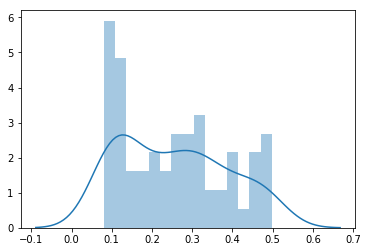

In [359]:
sns.distplot(disease_prob, bins=15)

Se puede observar que este modelo no tiene mucha "seguridad" a la hora de elegir la etiqueta "sano". Su distribución de probabilidad tiende a ser baja.

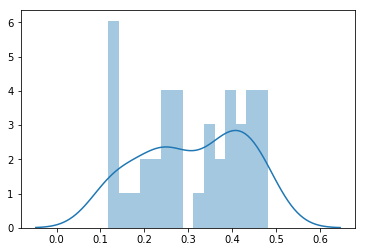

In [360]:
sns.distplot(no_disease_prob, bins=15)

Como podemos observar, este modelo tiene mayor seguridad al etiquetar a un paciente como "enfermo". Su distribución de probabilidad tiende a ser alta.

## Reutilizando nuestro modelo
Podemos guardar nuestro modelo para recuperarlo luego:

In [395]:
from datetime import datetime
now = datetime.now().strftime("%m-%m-%Y_%H-%M-%S") #no acepta ":"
path= "./models/rf__{}".format(now)
final_model.save(path)

In [396]:
from pyspark.ml.classification import RandomForestClassificationModel
rf2 = RandomForestClassificationModel.load(path)

### Notas
- En el dataset en kaggle dice que 1 es sano y 0 enfermo. En UCI dice 1 enfermo y 0 es sano.
- Tomamos lo que dice en kaggle, aunque estuve intentando contactar al que escribió para corroborar:
    [Dataset Kaggle](https://www.kaggle.com/ronitf/heart-disease-uci/discussion/105877)
